In [1]:
library(ggplot2)
library(RColorBrewer)
library(scales)
library(stringr)
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(reshape2))
theme_set(theme_bw())
options(repr.plot.width=8, repr.plot.height=5)

# Introduction

We have learned a little bit about the eukaryotic identity elements. If we test the full set (50 bit+) of tRNAs versus the quality set, we can learn about and dig into areas where the quality set may not be so high quality, and where the discovered identity elements may be inaccurate. The quality set is a subset of the full set of tRNAs, and has filtered for a few things, such as secondary structure score and isotype model-anticodon matching.

In [2]:
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
identities = identities %>% mutate(quality=quality & (!restrict | isotype == "iMet"))

In [3]:
load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('isotype-specific.RData')
load('consensus-IDEs.RData')
load('clade-isotype-specific-freqs.RData')

## 20ab

tRNAs contain a variable number of [insertions at position 20](http://zam.soe.ucsc.edu:5959/notebooks/identity/euk-isotypes/euk-tRNAs.ipynb#20a/20b). Does the quality + restricted set show a different distribution compared with the full set?

In [4]:
identities %>% group_by(quality & !restrict) %>% summarize(n())

,quality & !restrict,n()
1,FALSE,63292
2,TRUE,46517


In [5]:
insertionab = identities %>% 
  rowwise() %>% mutate(insertionab=nchar(str_replace_all(paste0(X20a, X20b, X20i1, X20i2, X20i3, X20i4), '[\\.\\-]', ''))) %>%
  mutate(quality=quality & (!restrict | isotype == "iMet")) %>%
  group_by(quality, insertionab) %>%
  summarize(count=n())

Warning message:
: Grouping rowwise data frame strips rowwise nature

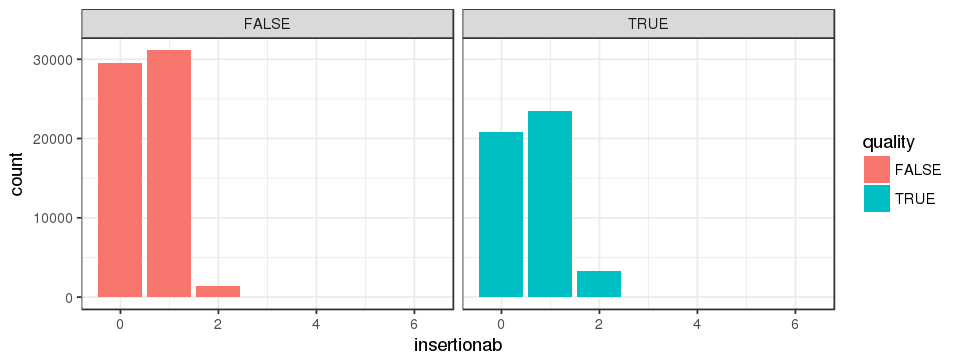

In [6]:
options(repr.plot.width=8, repr.plot.height=3)
insertionab %>% ggplot() + geom_bar(aes(x=insertionab, y=count, fill=quality), stat="identity") + facet_wrap(~ quality) 

## Anticodon usage

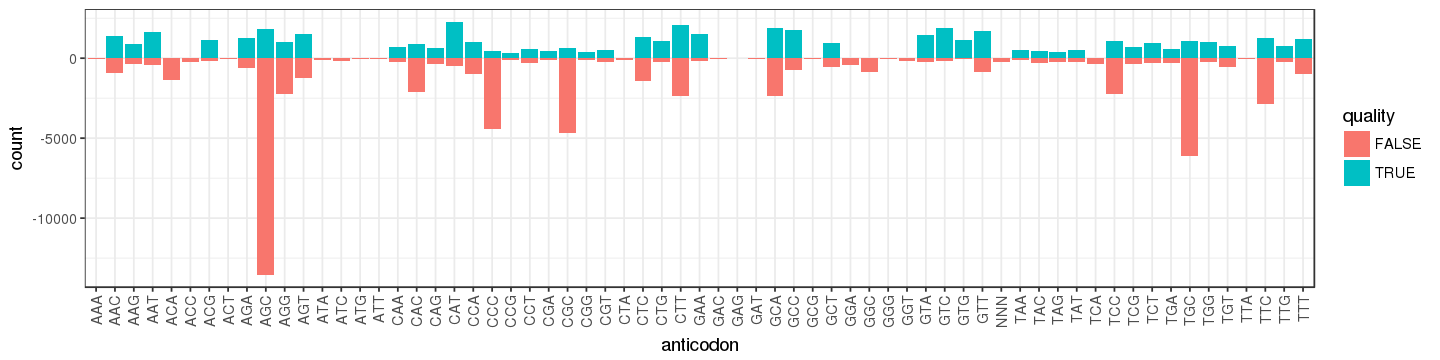

In [7]:
options(repr.plot.width=12, repr.plot.height=3)
ac_usage = identities %>% group_by(quality, anticodon) %>%
  summarize(count=n()) %>%
  rowwise %>% mutate(count=ifelse(quality[1], count[1], -count[1]))

ac_usage %>% ggplot() + geom_bar(aes(x=anticodon, y=count, fill=quality), stat='identity') + 
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

## 3D pairs

In [8]:
pairs = c("A:U", "U:A", "G:C", "C:G", "G:U", "U:G")
tert_pairs = identities %>%
  select(quality, X8.14, X9.23, X10.45, X15.48, X18.55, X19.56, X22.46, X26.44, X54.58) %>%
  mutate(quality=ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits")) %>%
  mutate(quality=factor(quality, levels=c("Other tRNAs > 55 bits", "Quality set tRNAs"))) %>%
  rowwise() %>%
  mutate(n3dpairs=sum(c((X8.14 %in% pairs), (X9.23 %in% pairs), (X10.45 %in% pairs), (X15.48 %in% pairs), (X18.55 %in% pairs), (X19.56 %in% pairs), (X22.46 %in% pairs), (X26.44 %in% pairs), (X54.58 %in% pairs)))) %>%
  ungroup() %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(quality, n3dpairs, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

Warning message:
: Removed 2 rows containing missing values (geom_bar).

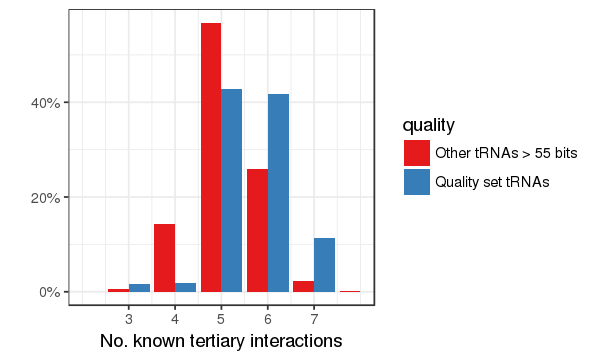

In [9]:
options(repr.plot.width=5, repr.plot.height=3)
tert_pairs %>% ggplot() + 
  geom_bar(aes(x=n3dpairs, y=freq, fill=quality), stat='identity', position='dodge') + 
  scale_x_continuous(limits=c(2, 8), breaks=c(3, 4, 5, 6, 7)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=brewer.pal(3, "Set1")[1:2]) + 
  ylab("") + xlab("No. known tertiary interactions")

## Mismatched pairs

In [89]:
paired_positions = c('X1.72', 'X2.71', 'X3.70', 'X4.69', 'X5.68', 'X6.67', 'X7.66', 'X10.25', 'X11.24', 'X12.23', 'X13.22', 'X27.43', 'X28.42', 'X29.41', 'X30.40', 'X31.39', 'X49.65', 'X50.64', 'X51.63', 'X52.62', 'X53.61')
mm_pairs = c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")
mismatched = identities %>% select(one_of("quality", paired_positions)) %>%
  mutate(quality=factor(ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits"), levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>%
  rowwise() %>%
  mutate(npairs=sum(c(X2.71 %in% mm_pairs), (X3.70 %in% mm_pairs), (X4.69 %in% mm_pairs), (X5.68 %in% mm_pairs), (X6.67 %in% mm_pairs), (X7.66 %in% mm_pairs), (X10.25 %in% mm_pairs), (X11.24 %in% mm_pairs), (X12.23 %in% mm_pairs), (X13.22 %in% mm_pairs), (X27.43 %in% mm_pairs), (X28.42 %in% mm_pairs), (X29.41 %in% mm_pairs), (X30.40 %in% mm_pairs), (X31.39 %in% mm_pairs), (X49.65 %in% mm_pairs), (X50.64 %in% mm_pairs), (X51.63 %in% mm_pairs), (X52.62 %in% mm_pairs), (X53.61 %in% mm_pairs))) %>%
  ungroup() %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(quality, npairs, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

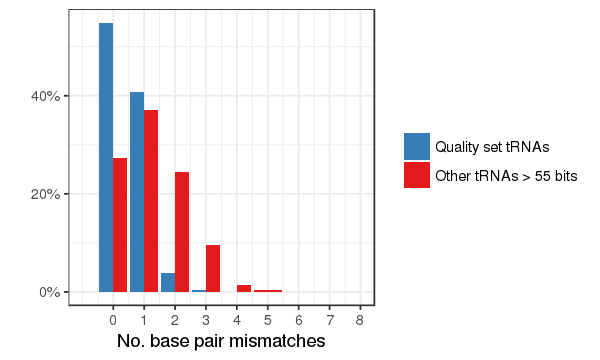

In [90]:
options(repr.plot.width=5, repr.plot.height=3)
mismatched %>% ggplot() + 
  geom_bar(aes(x=npairs, y=freq, fill=quality), stat='identity', position='dodge') + 
  scale_x_continuous(limits=c(-1, 8), breaks=c(0, 1, 2, 3, 4, 5, 6, 7, 8)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  ylab("") + xlab("No. base pair mismatches") + 
  guides(fill=guide_legend(title=NULL))

In [91]:
mismatched = identities %>% select(one_of("quality", "isotype", paired_positions)) %>%
  mutate(quality=factor(ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits"), levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>%
  rowwise() %>%
  mutate(X1.72=X1.72 %in% mm_pairs, X2.71=X2.71 %in% mm_pairs, X3.70=X3.70 %in% mm_pairs, X4.69=X4.69 %in% mm_pairs,  X5.68=X5.68 %in% mm_pairs, X6.67=X6.67 %in% mm_pairs, X7.66=X7.66 %in% mm_pairs, X10.25=X10.25 %in% mm_pairs, X11.24=X11.24 %in% mm_pairs, X12.23=X12.23 %in% mm_pairs, X13.22=X13.22 %in% mm_pairs, X27.43=X27.43 %in% mm_pairs, X28.42=X28.42 %in% mm_pairs, X29.41=X29.41 %in% mm_pairs, X30.40=X30.40 %in% mm_pairs, X31.39=X31.39 %in% mm_pairs, X49.65=X49.65 %in% mm_pairs, X50.64=X50.64 %in% mm_pairs, X51.63=X51.63 %in% mm_pairs, X52.62=X52.62 %in% mm_pairs, X53.61=X53.61 %in% mm_pairs) %>%
  gather(position, mismatched, -quality, -isotype) %>%
  group_by(quality, position, isotype) %>%
  summarize(count=sum(mismatched))

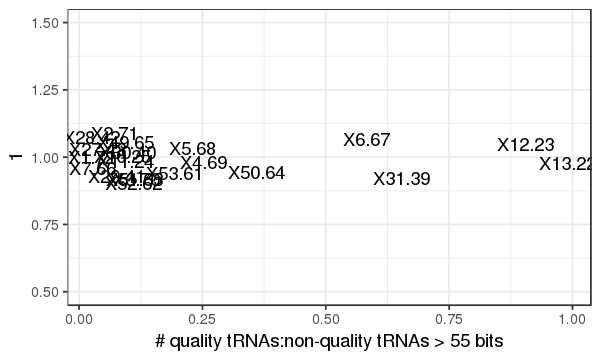

In [93]:
mismatched %>% group_by(position, quality) %>% summarize(count=sum(count)) %>% spread(quality, count) %>% mutate(ratio=`Quality set tRNAs`/`Other tRNAs > 55 bits`) %>% ggplot() + geom_text(aes(x=ratio, y=1, label=position), position = position_jitter(height=0.1)) + xlab("# quality tRNAs:non-quality tRNAs > 55 bits") + ylim(0.5, 1.5)

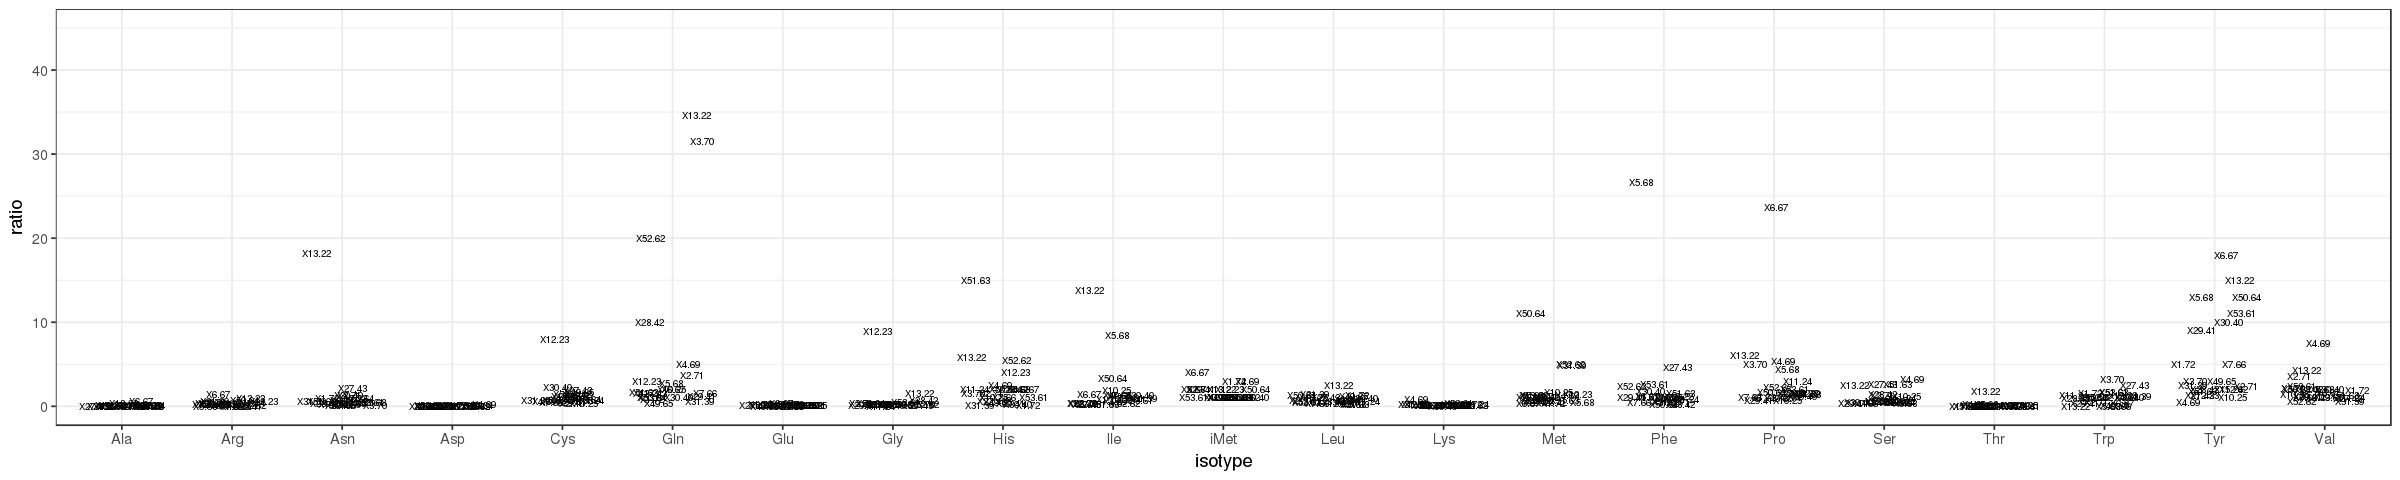

In [141]:
options(repr.plot.width=20, repr.plot.height=4)
# mismatched %>% group_by(position, quality) %>% summarize(count=sum(count)) %>% mutate(quality=factor(quality, levels=c("Quality set tRNAs", "Other tRNAS > 55 bits"))) %>% group_by(position) %>% arrange(quality) %>% summarize(count=paste0(count, collapse='/'))
# mismatched %>% group_by(position, isotype) %>% mutate(quality=factor(quality, levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>% arrange(quality) %>% summarize(count=paste0(count, collapse='/'))
mismatched %>% spread(quality, count) %>% mutate(ratio=(`Quality set tRNAs`+1)/(`Other tRNAs > 55 bits`+1)) %>%
  ggplot() + geom_text(aes(x=isotype, y=ratio, label=position), size=2, position=position_jitter(width=0.3)) + ylim(0, 45)

Most positions are 

In [ ]:
identities 

In [152]:
identities %>% select(species, isotype, clade, X31.39) %>%
  group_by(species, clade, isotype) %>%
  summarize(nmm = (sum(X31.39 %in% mm_pairs)+1)/(n() + 1 - sum(X31.39 %in% mm_pairs))) %>% filter(nmm > 0) %>%
arrange(desc(nmm))

,species,clade,isotype,nmm
1,danRer10,Vertebrata,Met,236
2,gasAcu1,Vertebrata,Met,147
3,manEsc6,Spermatophyta,Met,19
4,priPac1,Nematoda,Met,19
5,gadMor1,Vertebrata,Met,18
6,xenTro3,Vertebrata,Met,17.5
7,caeJap1,Nematoda,Met,17
8,sorBic3,Streptophyta,Met,17
9,bosTau8,Mammalia,Met,16
10,oviAri3,Mammalia,Met,16


## GC content

In [14]:
gc_content = identities %>% 
  mutate(quality=factor(ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits"), levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>% 
  select(GC, quality) %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(quality, GC, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

Warning message:
: Removed 6 rows containing missing values (geom_bar).

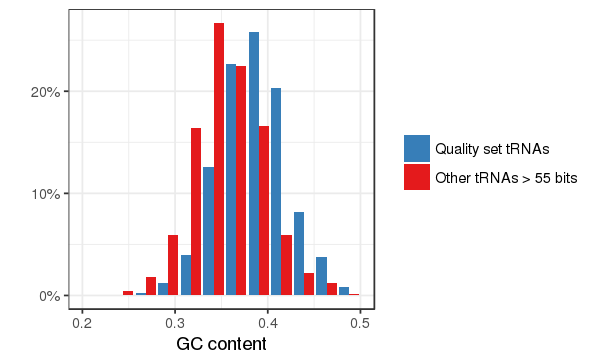

In [15]:
options(repr.plot.width=5, repr.plot.height=3)
gc_content %>% ggplot() + 
    geom_bar(aes(x=GC, y=freq, fill=quality), stat='identity', position='dodge') + 
    scale_x_continuous(limits=c(0.2, 0.5)) +
    scale_y_continuous(labels=percent_format()) +
    scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
    ylab("") + xlab("GC content") +
    guides(fill=guide_legend(title=NULL))

## Insertions/deletions

In [16]:
indels = identities %>% 
  mutate(quality=factor(ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits"), levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>% 
  select(insertions, deletions, quality) %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(insertions, deletions, quality, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

Warning message:
: Removed 7 rows containing missing values (geom_bar).Warning message:
: Removed 30 rows containing missing values (geom_bar).

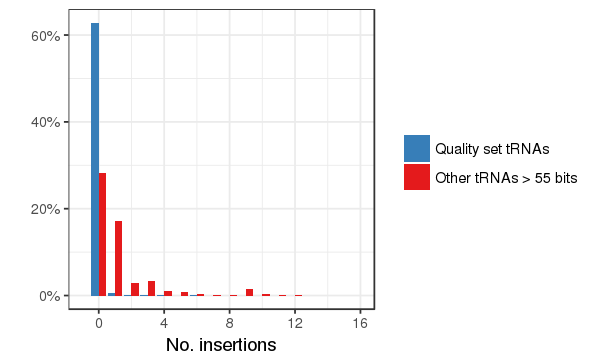

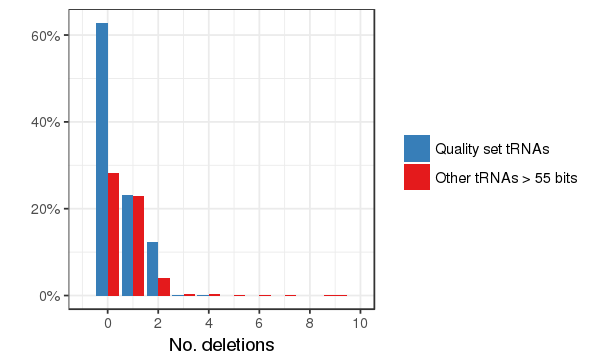

In [17]:
options(repr.plot.width=5, repr.plot.height=3)
indels %>% ggplot() + 
  geom_bar(aes(x=insertions, y=freq, fill=quality), stat='identity', position='dodge') + 
  scale_x_continuous(limits=c(-1, 16), breaks=c(0, 4, 8, 12, 16)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  ylab("") + xlab("No. insertions") +
  guides(fill=guide_legend(title=NULL))
indels %>% ggplot() + 
  geom_bar(aes(x=deletions, y=freq, fill=quality), stat='identity', position='dodge') + 
  scale_x_continuous(limits=c(-1, 10), breaks=c(0, 2, 4, 6, 8, 10)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  ylab("") + xlab("No. deletions") +
  guides(fill=guide_legend(title=NULL))

Position 17 is often "deleted". 

## Consensus element mismatches

In [18]:
missed = identities %>%
  mutate(quality=factor(ifelse(quality, "Quality set tRNAs", "Other tRNAs > 55 bits"), levels=c("Quality set tRNAs", "Other tRNAs > 55 bits"))) %>% 
  rowwise() %>%
  mutate(num_missed_IDEs=16 - sum(c(X8.14 == "U:A",
    X11.24 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
    X15 %in% c("A", "G", "C"),
    X18 %in% c("A", "G", "C"),
    X19.56 == "G:C",
    X21 %in% c("A", "C", "U"),
    X30.40 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
    X32 %in% c("C", "G", "U"),
    X33 %in% c("C", "U"),
    X37 %in% c("A", "C", "G"),
    X38 %in% c("A", "C", "U"),
    X53.61 %in% c("A:U", "G:C"),
    X54 %in% c("A", "C", "U"),
    X55 %in% c("C", "U"),
    X57 %in% c("A", "G"),
    X58 %in% c("A", "U")))) %>%
  mutate(quality=ifelse(quality, "Quality set", "tRNAs > 55 bits")) %>%
  select(num_missed_IDEs, quality)  %>%
  ungroup() %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(quality, npairs, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

ERROR: Error in mutate_impl(.data, dots): invalid to change the storage mode of a factor


In [19]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(missed) + geom_bar(aes(x=num_missed_IDEs, fill=quality), position='dodge') +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  xlab("No. tRNAs") + ylab("No. missed consensus IDEs") +
  guides(fill=guide_legend(title=NULL))

ERROR: Error in ggplot(missed): object 'missed' not found
